# Project: AI Learns to TikTok

---

In this notebook, we will prepare our dataset.  

Use the links below to navigate the notebook:
- [Step 1](#step1): Download dance video
- [Step 2](#step2): Split video
- [Step 3](#step3): Extract audio
- [Step 4](#step4): Create spectrograms from audio
- [Step 5](#step5): Run OpenPose and create annotations.csv


<a id='step1'></a>
## Step 1: Download dance video

The requirements for our training video data are as follows:
- There can only be one dancer
- The dancers should be positioned in the centre
- The dancers should be of similar proportion
- There should be minimal movement along the camera axis

With that in mind, I found Just Dance videos to be appropriate. 

Note: One caveat might be the noise in the audio from "scroring" eg. the game plays a sound when a move is registered as "Perfect". The model may not perform well with actual music that do not have these sounds.

The default video used in this notebook will be [Just Dance 2020 - Kill This Love (Extreme) - Megastar](https://www.youtube.com/watch?v=R36QUnxTiXk)

<a id='step2'></a>
## Step 2: Split video

Here we will split our video into 15 second intervals(maximum length allowed for TikTok videos)

In [26]:
# Set input video path
source_video_path = "./videos/letskillthislove.mp4"
# Set path to store 15s video clips
videoclip_target_dir = "./train_set/video/"

In [ ]:
#-#-#-# Do NOT modify the code below this line. #-#-#-#

import os
import moviepy.editor as mp

basename = os.path.basename(source_video_path)
videoname = os.path.splitext(basename)[0]

clip = mp.VideoFileClip(source_video_path)

for i, j in enumerate(range(0, int(clip.duration), 15)):
    if j+15 < clip.duration:
        snippet = clip.subclip(j, j+15)
        snippet.write_videofile(
            f"{videoclip_target_dir}{videoname}{i}.mp4", temp_audiofile="temp-audio.m4a", remove_temp=True, audio_codec="aac")

<a id='step3'></a>
## Step 3: Extract audio

We will now extract the audio from our 15s clips into mp3 files

In [19]:
# Set path to store 15s audio clips
audioclip_target_dir = "./train_set/audio/"

In [ ]:
#-#-#-# Do NOT modify the code below this line. #-#-#-#
for basename in os.listdir(videoclip_target_dir):
    videoname = os.path.splitext(basename)[0]
    input_video = mp.VideoFileClip(videoclip_target_dir + f"/{basename}")
    input_video.audio.write_audiofile(audioclip_target_dir + "/" + videoname + ".mp3")

<a id='step4'></a>
## Step 4: Create spectrograms from audio

We will now create spectrograms from our 15s audio clips

In [22]:
# Set path to store spectrograms
spectrogram_target_dir = "./train_set/spectrogram/"

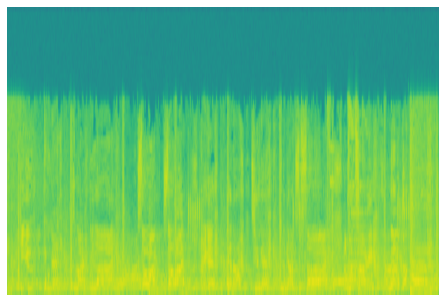

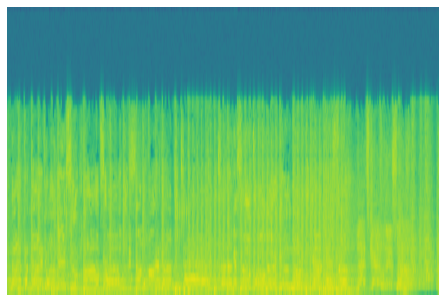

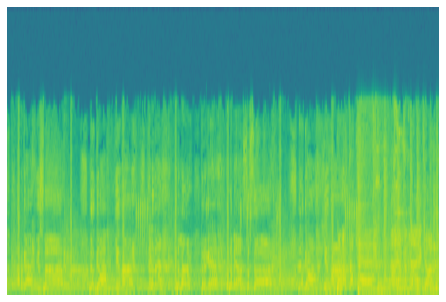

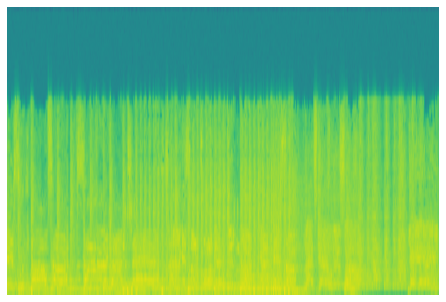

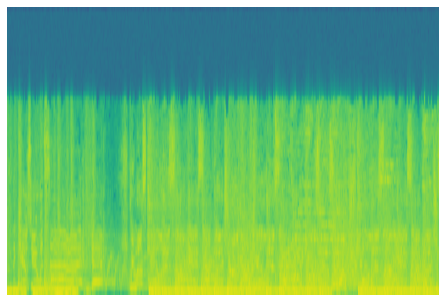

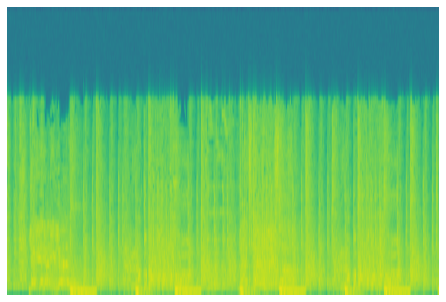

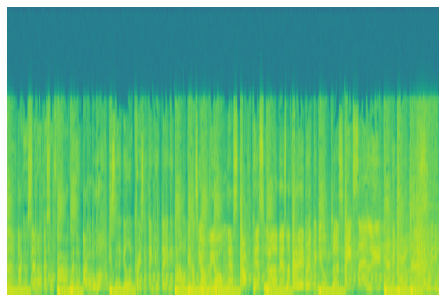

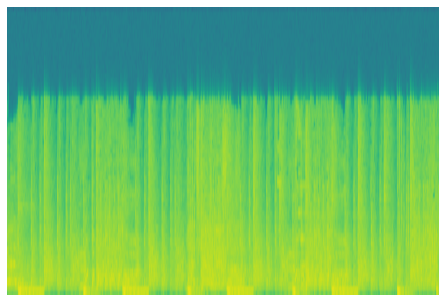

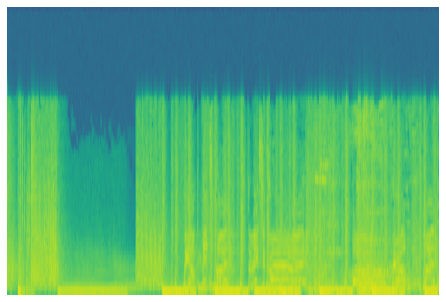

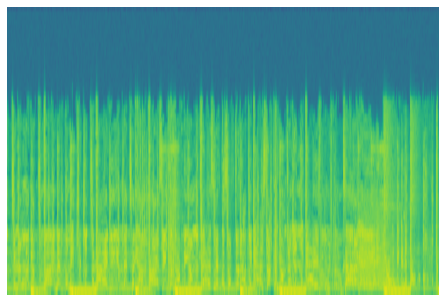

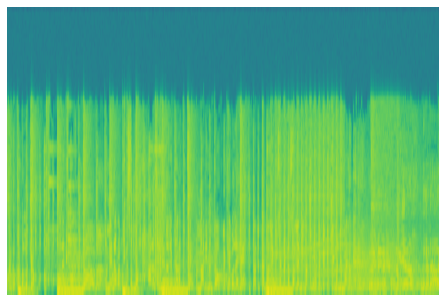

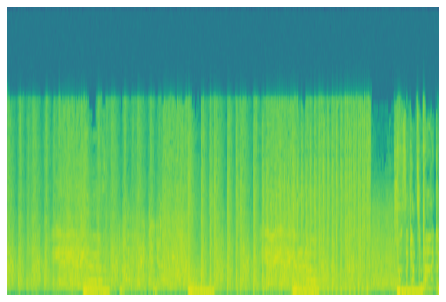

In [28]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.io import wavfile
from tempfile import mktemp

audio_clips = os.listdir(audioclip_target_dir)

for audio_name in audio_clips:
    mp3_audio = AudioSegment.from_file(
        audioclip_target_dir + audio_name, format="mp3")  # read mp3
    wname = mktemp('.wav')  # use temporary file
    mp3_audio.export(wname, format="wav")  # convert to wav
    FS, data = wavfile.read(wname)  # read wav file

    # save only spectrogram (minus axes or anything else)
    fig, ax = plt.subplots(1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('tight')
    ax.axis('off')

    # Note [:, 0] I'm only using left audio
    # The JustDance feedback sounds are left in the tracks
    ax.specgram(data[:, 0], Fs=FS, NFFT=128, noverlap=0)
    # Remove .mp3
    audio_basename = os.path.splitext(audio_name)[0]
    fig.savefig(spectrogram_target_dir +
                audio_basename, dpi=300)
    # Uncomment the next line to hide inline plots
    # plt.close(fig)

<a id='step5'></a>
## Step 5: Run OpenPose and create annotations.csv

The last step will be running OpenPose on our 15s dance clips and adding the predicted pose_coordinates to an annotations.csv file from which we will build our dataloader in the next notebook.

In [27]:
# Set path to OpenPose model folder
op_model_folder = "./openpose/models/"
# Set path to store annotations.csv
annotations_path = "./train_set/annotations.csv"

In [ ]:
from sys import platform
import os
import cv2
import numpy as np
import sys
import pandas as pd

if True:
    sys.path.append('./openpose/python')
    from openpose import pyopenpose as op

# Custom Params (refer to include/openpose/flags.hpp for more parameters)
params = dict()
params["model_folder"] = op_model_folder

# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

train_df = pd.DataFrame(columns=np.arange(start=0, stop=450, step=2))

video_folder = os.listdir(videoclip_target_dir)
for video_name in video_folder:
    cap = cv2.VideoCapture(videoclip_target_dir + "/" + video_name)
    count = 0
    while cap.isOpened():
        ret, image = cap.read()
        if ret:
            # Process Image
            datum = op.Datum()
            datum.cvInputData = image
            opWrapper.emplaceAndPop(op.VectorDatum([datum]))
            train_df.at[video_name, count] = str(datum.poseKeypoints)
            train_df.to_csv(
                annotations_path)
            count += 2
            cap.set(1, count)
        else:
            cap.release()
            break